In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install python_speech_features #Feature extraction module

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp37-none-any.whl size=5887 sha256=59e51fe101c59bffc35769238326e57f584470490d5602f7f844b79ac5d2e449
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [3]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np

from tempfile import TemporaryFile
import os
import pickle
import random 
import operator

import math
import numpy as np
from collections import defaultdict

In [4]:
def distance(instance1, instance2, k): #Function to calculate distance between neighbors
  distance =0;
  mm1 = instance1[0]
  cm1 = instance1[1]
  mm2 = instance2[0]
  cm2 = instance2[1]
  distance = np.trace(np.dot(np.linalg.inv(cm2), cm1)) 
  distance+=(np.dot(np.dot((mm2-mm1).transpose() , np.linalg.inv(cm2)) , mm2-mm1 )) 
  distance+= np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
  distance-= k
  return distance

In [5]:
def getNeighbors(trainingSet, instance, k): #Function to define and locate neighors
    distances = []
    for x in range (len(trainingSet)):
        dist = distance(trainingSet[x], instance, k )+ distance(instance, trainingSet[x], k)
        distances.append((trainingSet[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [6]:
def getResponse(neighbors): #Main Classifier
    classVote = {}

    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response]+=1 
        else:
            classVote[response]=1

    sorter = sorted(classVote.items(), key = operator.itemgetter(1), reverse=True)
    return sorter[0][0]

In [7]:
def getAccuracy(testSet, predictions): #Function to get prediction accuracy
    correct = 0 
    for x in range (len(testSet)):
        if testSet[x][-1]==predictions[x]:
            correct+=1
    return 1.0*correct/len(testSet)

In [9]:
cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [10]:
directory = 'genres'
f= open("my.dat" ,'wb')  #Creating mfcc and storing it in dat file
i=0

for folder in os.listdir(directory):
    i+=1
    if i==11 :
        break 	
    for file in os.listdir(directory+"/"+folder):	
        (rate,sig) = wav.read(directory+"/"+folder+"/"+file)
        mfcc_feat = mfcc(sig,rate ,winlen=0.020, appendEnergy = False)
        covariance = np.cov(np.matrix.transpose(mfcc_feat))
        mean_matrix = mfcc_feat.mean(0)
        feature = (mean_matrix , covariance , i)
        pickle.dump(feature , f)

f.close()

In [23]:
dataset = []
def loadDataset(filename , split , trSet , teSet):  #Split Dataset
    with open("my.dat" , 'rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break	

    for x in range(len(dataset)):
        if random.random() <split :			
            trSet.append(dataset[x])
        else:
            teSet.append(dataset[x])	

trainingSet = []
testSet = []
loadDataset("my.dat" , 0.60, trainingSet, testSet)

In [24]:
predictions=[]
k = 5
for x in range(len(testSet)):
		neighbors = getNeighbors(trainingSet, testSet[x], k)
		result = getResponse(neighbors)
		predictions.append(result)
    #Uncomment following line to see the individual predicted results.
		#print('> predicted=' + repr(result) + ', actual=' + repr(testSet[x][-1]))
accuracy = getAccuracy(testSet, predictions)
print('Accuracy: ' + repr(accuracy) + '%')

Accuracy: 0.717741935483871%


In [15]:
results = defaultdict(int)

i=1
for folder in os.listdir(directory):
    results[i]=folder
    i+=1
print(results)

(rate,sig) = wav.read('Check2.wav')
mfcc_feat = mfcc(sig,rate,winlen=0.020,appendEnergy=False)
covariance = np.cov(np.matrix.transpose(mfcc_feat))
mean_matrix = mfcc_feat.mean(0)
feature = (mean_matrix,covariance,0)

prediction = getResponse(getNeighbors(dataset ,feature , 5)) # Predicting genre of random input audio file.
print(prediction)                                            # Ignore the frame length warning, it is just because size of audio file is big
print(results[prediction])

defaultdict(<class 'int'>, {1: 'blues', 2: 'classical', 3: 'country', 4: 'disco', 5: 'hiphop', 6: 'jazz', 7: 'metal', 8: 'pop', 9: 'rock', 10: 'reggae'})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  if __name__ == '__main__':


8
pop


In [16]:
import librosa
audio_path = 'Check2.wav'
x , sr = librosa.load(audio_path) #Shape feature extraction using librosa
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(705600,) 22050


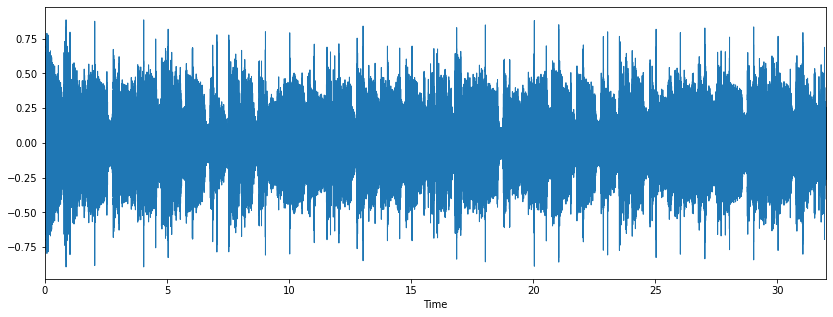

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

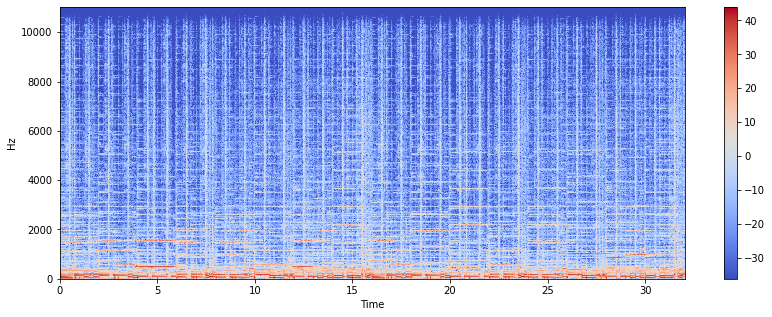

In [18]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()